# Generate a Noise Model by Bootstrapping
We will use pairs of noisy images $x_i$ and clean pseudo ground truth $s_i$ (created by performing Noise2Void in notebooks `1_N2VTraining.ipynb`) to estimate the conditional distribution $p(x_i|s_i)$. Histogram-based and Gaussian Mixture Model-based noise models are generated and saved. No additional, calibration data is used.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread

from ppn2v.noise_models import gaussianMixtureNoiseModel, histNoiseModel
from ppn2v import prediction, utils

device = utils.getDevice()

CUDA available? True


### Download data
Download the data from  https://owncloud.mpi-cbg.de/index.php/s/lt3yecHQMKJnJlB/download. Here we show the pipeline for Mouse actin dataset. Save the dataset at an appropriate location. For us, the path is data folder which exists at `../../../`. For Mouse actin, the data to be denoised is named ```sample_attempt2.tif```. 

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('../../../data/Mouse actin/'):
    os.mkdir('../../../data/Mouse actin/')

zipPath="../../../data/Mouse actin/Mouse_actin.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve(' https://owncloud.mpi-cbg.de/index.php/s/lt3yecHQMKJnJlB/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("../../../data/Mouse actin/")


### The data

The noise model is a characteristic of your camera. 
The downloaded data folder contains a set of calibration images (For the Mouse actin dataset, it is ```diaphragm.tif``` and the data to be denoised is named ```sample_attempt2.tif```). Here we bootstrap a suitable histogram noise model after denoising the noisy images with Noise2Void and then using these denoised images as pseudo GT.

### Specify ```path```, ```dataName```,  ```n_gaussian```, ```n_coeff```
Ensure that ```dataName``` is set same as in ```1_N2VTraining.ipynb```

In [3]:
path="../../../data/Mouse actin/"
dataName = 'mouseactin' # Name of the noise model 
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.

In [4]:
observation= imread(path+'sample_attempt2.tif') #Load the appropriate data
nameHistNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
nameGMMNoiseModel = 'GMMNoiseModel_'+dataName+'_'+str(n_gaussian)+'_'+str(n_coeff)+'_'+'bootstrap'
nameN2VModel = dataName+'_n2v'
net=torch.load(path+"last_"+nameN2VModel+".net")

In [5]:
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]
dataTest = observation

for index in range(dataTest.shape[0]):

    im=dataTest[index]
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means = prediction.tiledPredict(im, net, ps=256, overlap=48,
                                    device=device, noiseModel=None)
    resultImgs.append(means)
    inputImgs.append(im)
    print ("image:", index)

image: 0
image: 1
image: 2
image: 3
image: 4
image: 5
image: 6
image: 7
image: 8
image: 9
image: 10
image: 11
image: 12
image: 13
image: 14
image: 15
image: 16
image: 17
image: 18
image: 19
image: 20
image: 21
image: 22
image: 23
image: 24
image: 25
image: 26
image: 27
image: 28
image: 29
image: 30
image: 31
image: 32
image: 33
image: 34
image: 35
image: 36
image: 37
image: 38
image: 39
image: 40
image: 41
image: 42
image: 43
image: 44
image: 45
image: 46
image: 47
image: 48
image: 49
image: 50
image: 51
image: 52
image: 53
image: 54
image: 55
image: 56
image: 57
image: 58
image: 59
image: 60
image: 61
image: 62
image: 63
image: 64
image: 65
image: 66
image: 67
image: 68
image: 69
image: 70
image: 71
image: 72
image: 73
image: 74
image: 75
image: 76
image: 77
image: 78
image: 79
image: 80
image: 81
image: 82
image: 83
image: 84
image: 85
image: 86
image: 87
image: 88
image: 89
image: 90
image: 91
image: 92
image: 93
image: 94
image: 95
image: 96
image: 97
image: 98
image: 99


(100, 1024, 1024)


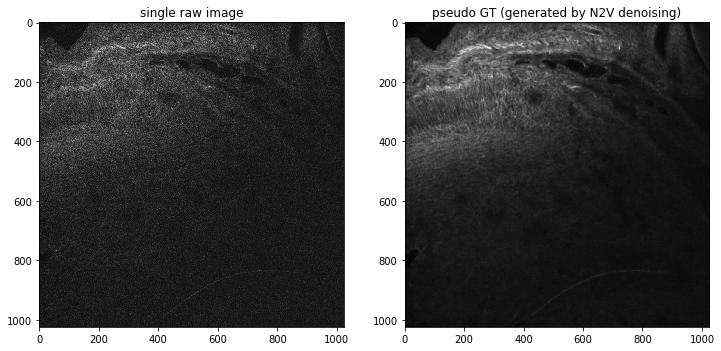

In [6]:
# In bootstrap mode, we estimate pseudo GT by using N2V denoised images.
signal = np.array(resultImgs)   
# Let's look the raw data and our pseudo ground truth signal
print(signal.shape)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 2)
plt.title(label='pseudo GT (generated by N2V denoising)')
plt.imshow(signal[0],cmap='gray')
plt.subplot(1, 2, 1)
plt.title(label='single raw image')
plt.imshow(observation[0],cmap='gray')
plt.show()

### Creating the Histogram Noise Model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a histogram based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [7]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
# The dataset is clipped to values between 0 and 255.
minVal, maxVal = 305, 2905
bins = 260

# We are creating the histogram.
# This can take a minute.
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, observation, signal)

# Saving histogram to disc.
np.save(path+nameHistNoiseModel+'.npy', histogram)
histogramFD=histogram[0]

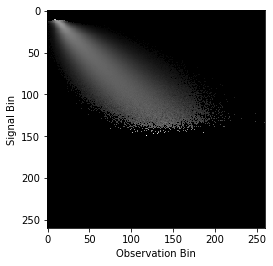

In [8]:
# Let's look at the histogram-based noise model
plt.xlabel('Observation Bin')
plt.ylabel('Signal Bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()

### Creating the GMM noise model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a GMM based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [9]:
min_signal=np.percentile(signal, 0.5)
max_signal=np.percentile(signal, 99.5)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Minimum Signal Intensity is 482.1240234375
Maximum Signal Intensity is 1139.848145751952


Iterating the noise model training for `n_epoch=4000`, `batchSize=25000` and `min_sigma` = 200 works the best for `Mouse actin` dataset. 

In [10]:
gaussianMixtureNoiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(min_signal = min_signal, max_signal =max_signal, path=path, weight = None, n_gaussian = n_gaussian, n_coeff = n_coeff, min_sigma = 200, device = device)
gaussianMixtureNoiseModel.train(signal, observation, batchSize = 25000, n_epochs = 4000, learning_rate=0.1, name = nameGMMNoiseModel, lowerClip = 0.5, upperClip = 99.5)

0 11.143829345703125
100 5.688204288482666
200 5.688766956329346
300 5.671430587768555
400 5.677550315856934
500 5.671911239624023
600 5.658308506011963
700 5.670894622802734
800 5.651740074157715
900 5.672213554382324
1000 5.668949127197266
1100 5.659412384033203
1200 5.653965473175049
1300 5.663841247558594
1400 5.655548572540283
1500 5.657532215118408
1600 5.664562225341797
1700 5.679928779602051
1800 5.658746719360352
1900 5.667648792266846
2000 5.659961700439453
2100 5.654596328735352
2200 5.660254001617432
2300 5.664714813232422
2400 5.648351669311523
2500 5.649111747741699
2600 5.662799835205078
2700 5.650650501251221
2800 5.666842460632324
2900 5.664298057556152
3000 5.663782119750977
3100 5.659177303314209
3200 5.661134243011475
3300 5.66054105758667
3400 5.675787448883057
3500 5.66149377822876
3600 5.658702373504639
3700 5.659117221832275
3800 5.660850524902344
3900 5.669098377227783

The trained parameters (GMMNoiseModel_mouseactin_3_2_bootstrap) is saved at location: ../../

### Visualizing the Histogram-based and GMM-based noise models

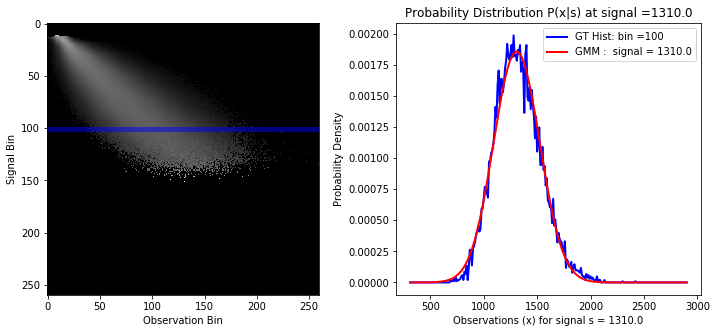

In [11]:
utils.plotProbabilityDistribution(signalBinIndex=100, histogram=histogramFD, gaussianMixtureNoiseModel=gaussianMixtureNoiseModel, min_signal=minVal, max_signal=maxVal, n_bin= bins, device=device)